# Supervised Learning

In [18]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score,roc_curve, accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
df = pd.read_csv('cleaned_data.csv')

In [19]:
def execute_fit_predict(classifier_model, X_train, y_train, X_test):
    classifier_model.fit(X_train, y_train)
    pred = classifier_model.predict(X_test)
    return pred

In [20]:
def execute_evaluate(y_test, pred=None, pred_proba=None):
    # get confusion matrix
    confusion = confusion_matrix( y_test, pred)
    # get accuracy score
    accuracy = accuracy_score(y_test , pred)
    # get precision
    precision = precision_score(y_test , pred)
    # get recall
    recall = recall_score(y_test , pred)
    # get f1 score
    f1 = f1_score(y_test,pred)
    # get auc score
    roc_auc = roc_auc_score(y_test, pred_proba)
    # get fpr, tpr
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    
    result = {
        "roc_auc": [roc_auc.round(4)],
        "precision": [precision.round(4)],
        "recol": [recall.round(4)],
        "f1": [f1.round(4)],
        "accuracy": [accuracy.round(4)],
    }

    return (confusion,pd.DataFrame(result),{"fpr":fpr,"tpr":tpr,"auc":roc_auc})

In [21]:
def execute_cross_validation(classifier_model, X_features, y_targets, folds):
    kfold = KFold(n_splits=folds)
    scores = []
    for i , (train_index, test_index) in enumerate(kfold.split(X_features)):
        # Create index pointing to training and validation data by cross-validation from the data
        X_train, X_test = X_features.values[train_index], X_features.values[test_index]
        y_train, y_test = y_targets.values[train_index], y_targets.values[test_index]
        
        # train and fit
        pred = execute_fit_predict(classifier_model=classifier_model, X_train=X_train, y_train=y_train, X_test=X_test)
        pred_proba = classifier_model.predict_proba(X_test)[:,1]
        score = execute_evaluate(y_test=y_test, pred=pred, pred_proba=pred_proba)
        scores.append({"index":i, "score":score })
    return sorted(scores, key=lambda x: x['score'][1]['roc_auc'].iloc[0], reverse=True)

In [22]:
def roc_curve_plot(y_test ,X_test, classifier_models=None, labels=[""], title=""):
    fig, _ = plt.subplots(constrained_layout=True, figsize=(4, 4))
    for idx, classifier_model in enumerate(classifier_models):
        y_pred_proba = classifier_model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, 'o-', ms=1, label="{} auc={}".format(labels[idx],auc.round(4)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend(loc=4)
    plt.title('ROC Curve')    
    plt.show()

In [23]:
def evaluate_visually(evaluation, fig_title=""):
    fig, axs = plt.subplots(figsize=(10, 4), ncols=3, constrained_layout=True )
    fig.suptitle(fig_title, fontsize=12)
    
    axs[0].title.set_text("SCORE")
    axs[1].title.set_text("Counfusion_Matrix")
    axs[2].title.set_text("ROC Curve")
    
    sns.heatmap(evaluation[0], annot=True, ax=axs[1], cbar=False)
    sns.heatmap(evaluation[1], cmap="YlGnBu", annot=True, ax=axs[0], cbar=False)
    
    axs[2].plot(evaluation[2]["fpr"], evaluation[2]["tpr"], 'o-', ms=1)     
    axs[2].plot([0, 1], [0, 1], 'k--')

# Decision Tree
#### Without cross validation vs With cross validation

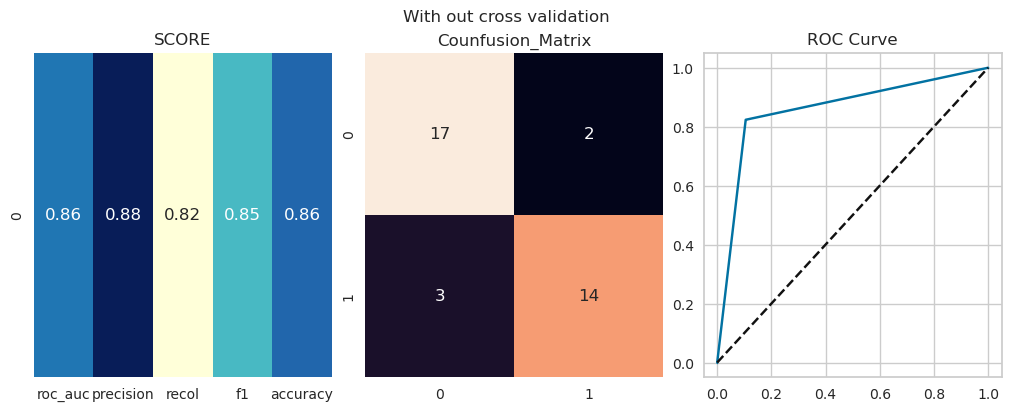

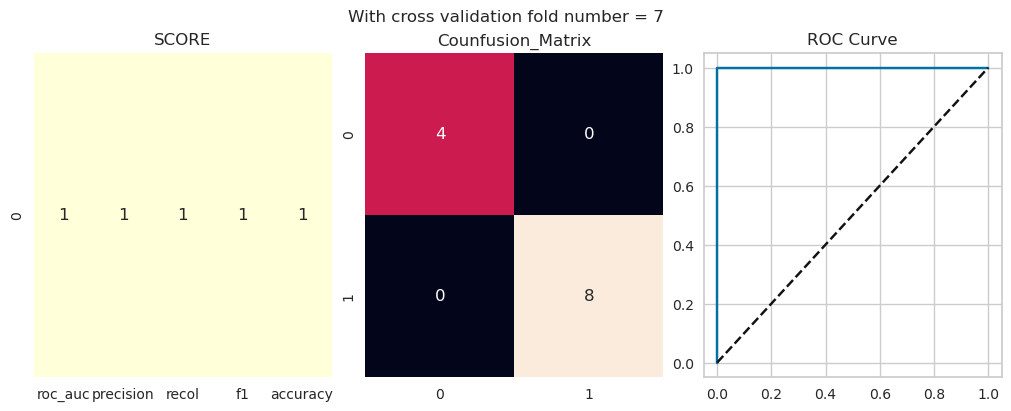

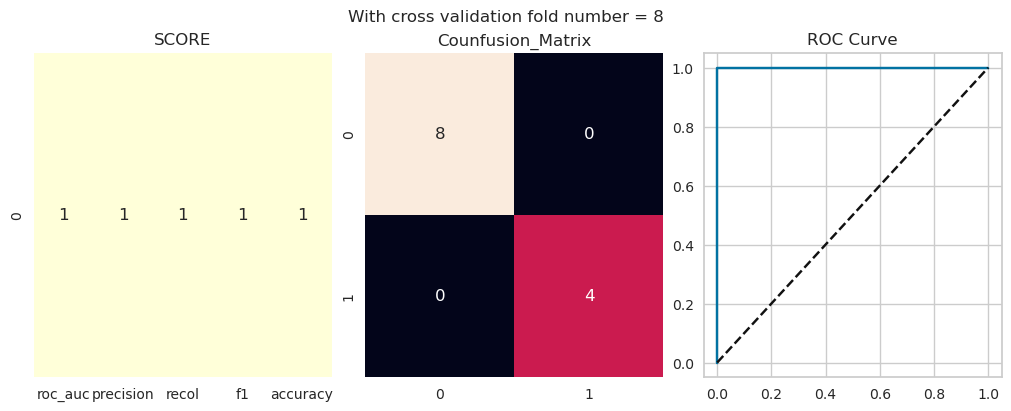

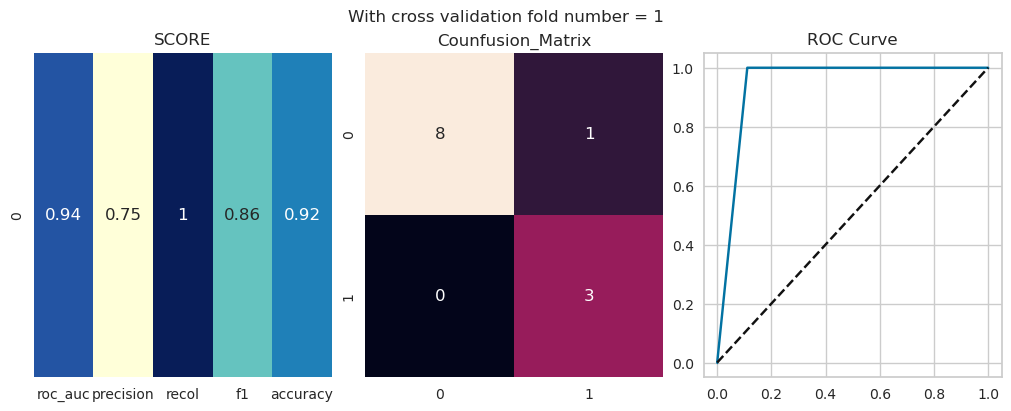

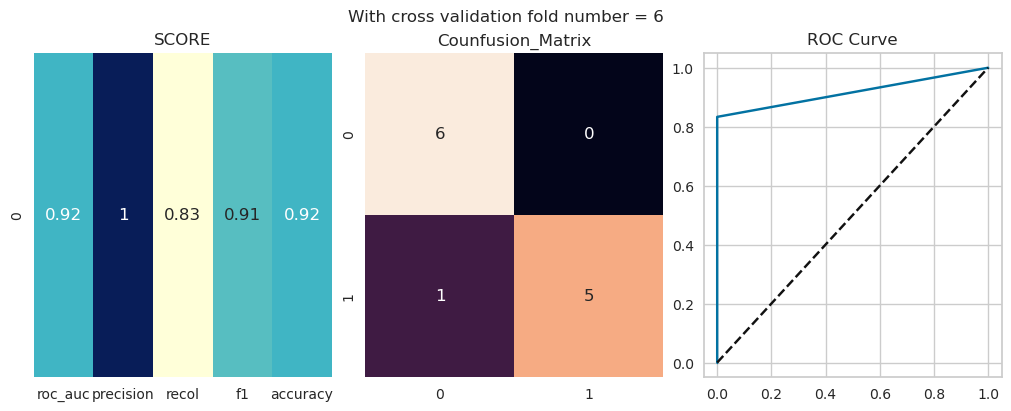

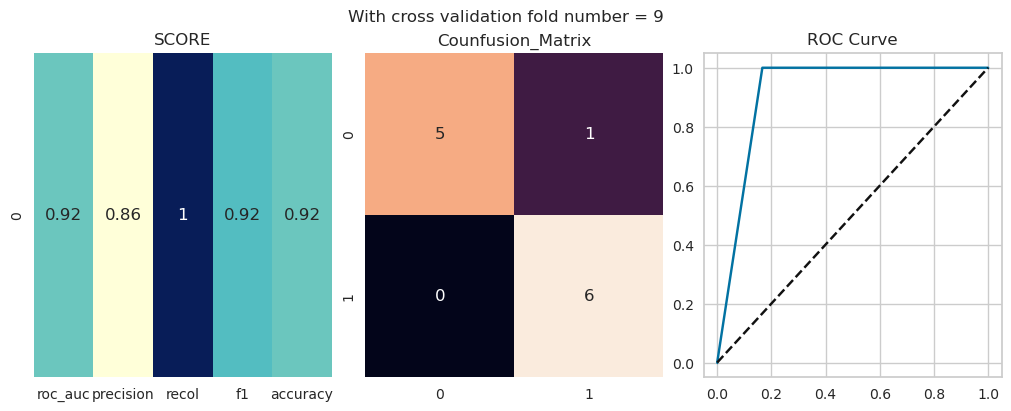

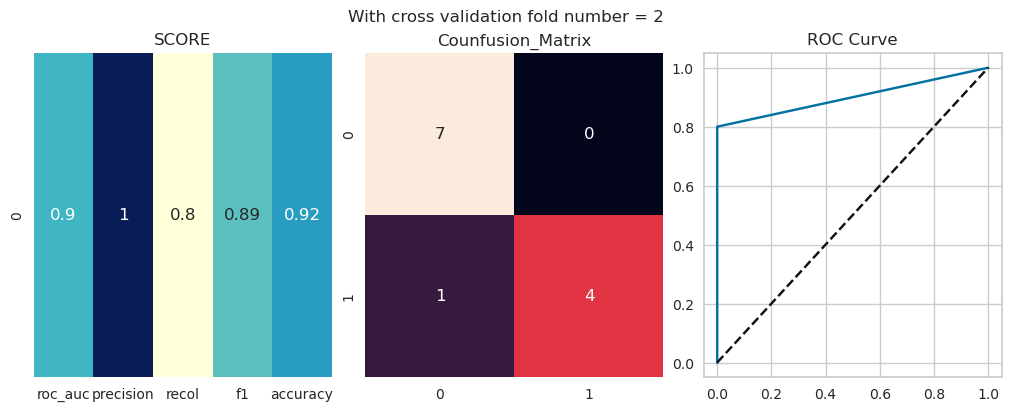

In [24]:
X_features = df.drop(['Fraud'], axis=1)
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.3)

decision_tree = DecisionTreeClassifier()

pred = execute_fit_predict(classifier_model=decision_tree, X_train=X_train, y_train=y_train, X_test=X_test)
pred_proba = decision_tree.predict_proba(X_test)[:,1]
evaluation = execute_evaluate(y_test=y_test,pred=pred,pred_proba=pred_proba)
evaluate_visually(evaluation=evaluation, fig_title="With out cross validation")

cross_validation_scores = execute_cross_validation(classifier_model=decision_tree, X_features=X_features, y_targets=y_targets, folds=10)
for idx, x in enumerate(cross_validation_scores):
    if(idx > 5):break
    evaluate_visually(x['score'], fig_title="With cross validation fold number = {}".format(x['index']))

# cross_val_score_API = cross_val_score(decision_tree, X_features, y_targets, scoring = 'roc_auc', cv=10)
# print(cross_val_score_API)


# Random Forest
#### Without cross validation vs With cross validation

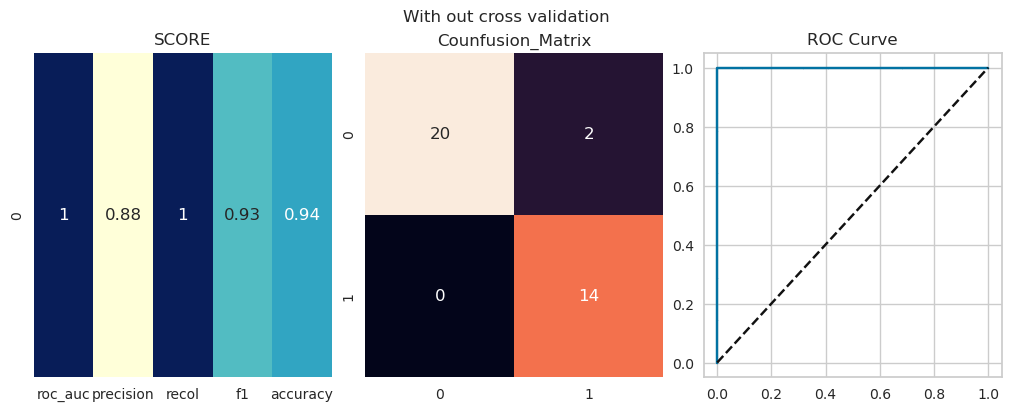

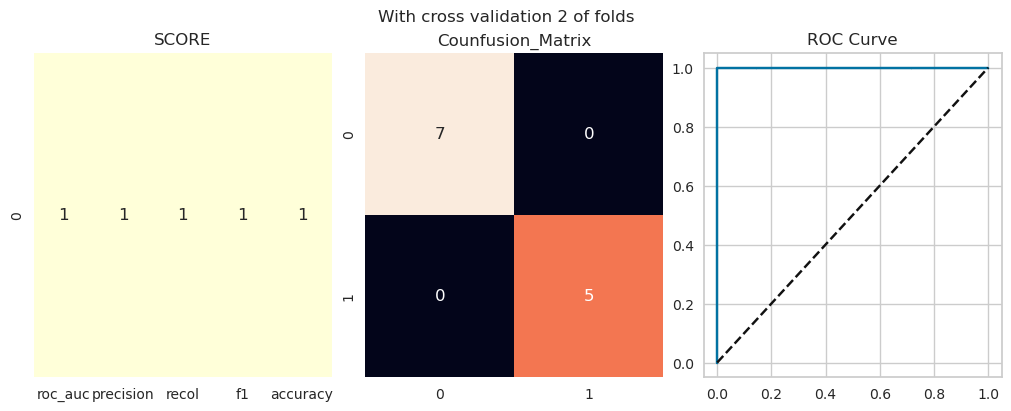

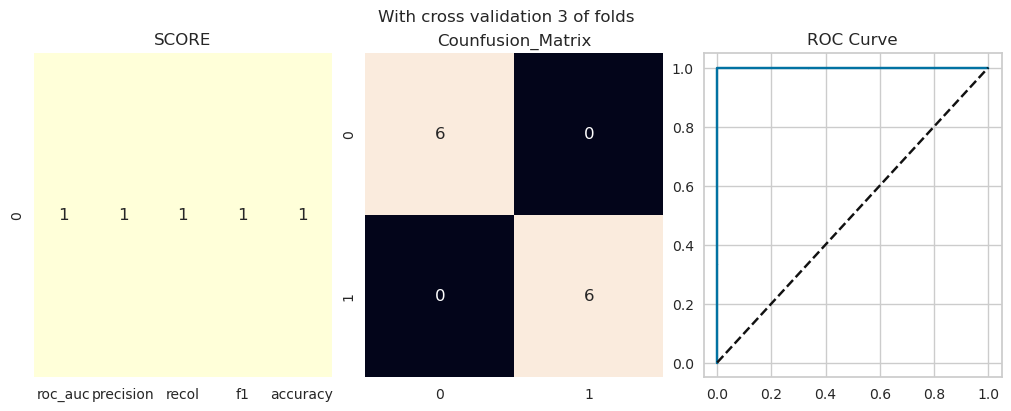

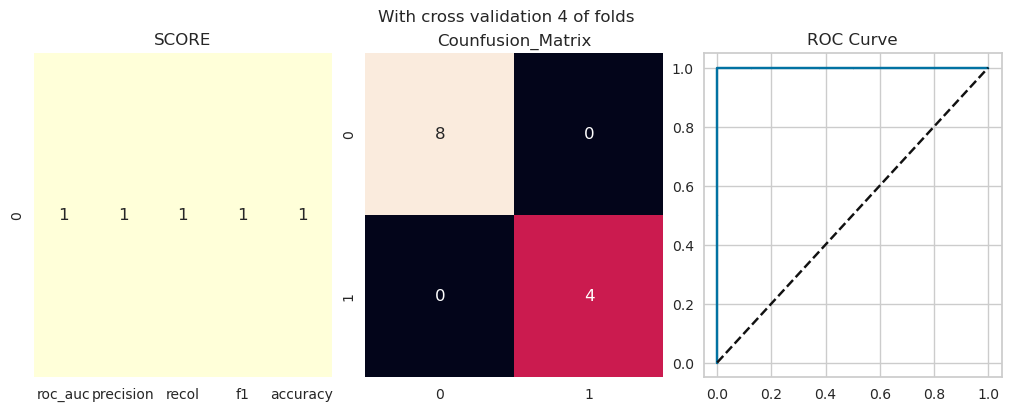

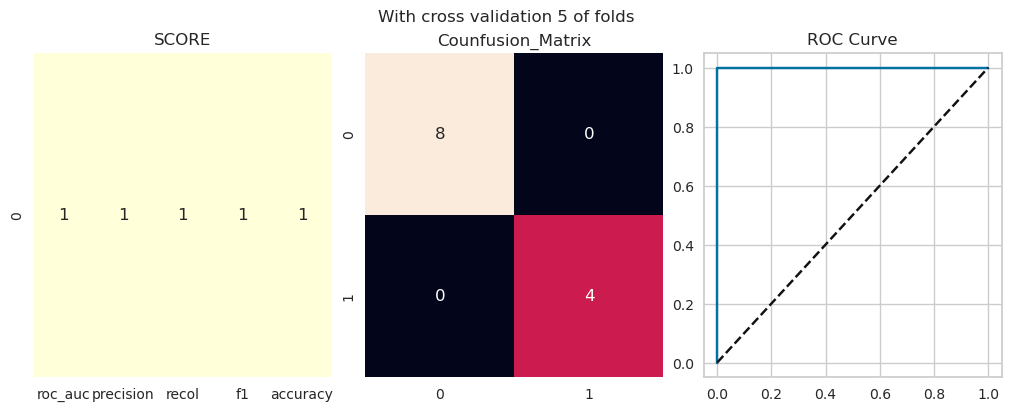

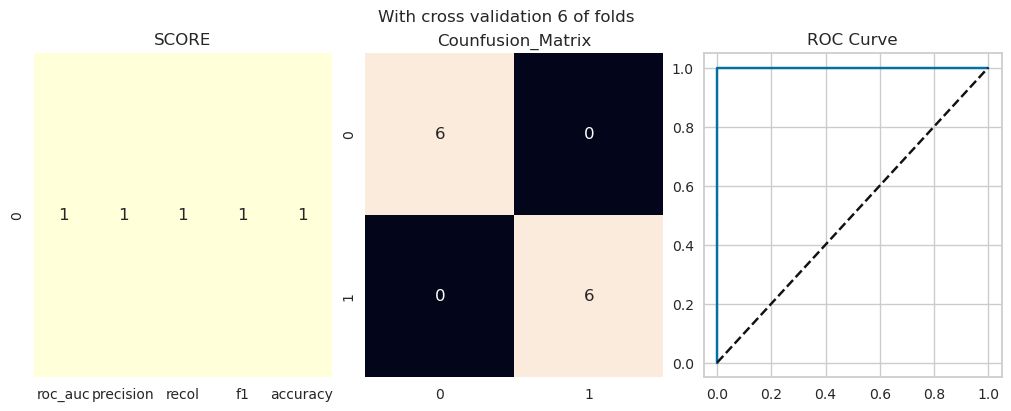

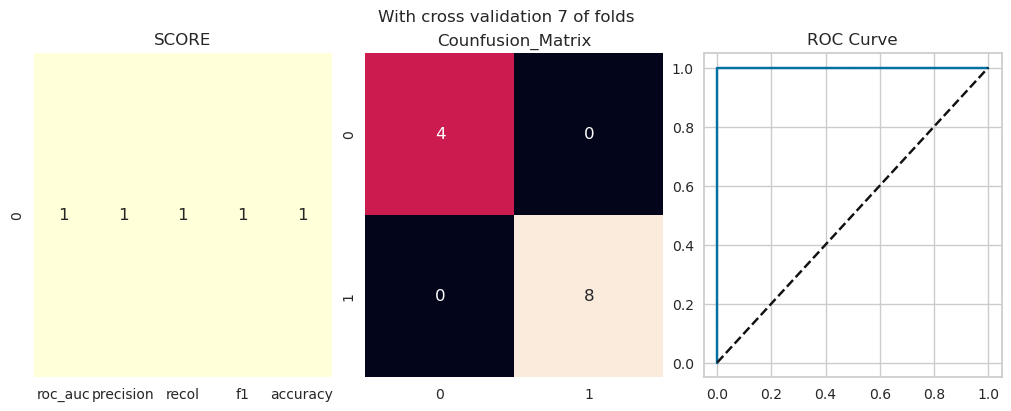

In [25]:
X_features = df.drop(['Fraud'], axis=1)
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.3)

random_forest = RandomForestClassifier()

pred = execute_fit_predict(classifier_model=random_forest, X_train=X_train, y_train=y_train, X_test=X_test)
pred_proba = random_forest.predict_proba(X_test)[:,1]
evaluation = execute_evaluate(y_test=y_test,pred=pred,pred_proba=pred_proba)
evaluate_visually(evaluation, fig_title="With out cross validation")

cross_validation_scores = execute_cross_validation(classifier_model=random_forest, X_features=X_features, y_targets=y_targets, folds=10)
for idx, x in enumerate(cross_validation_scores):
    if(idx > 5):break
    evaluate_visually(x['score'], fig_title="With cross validation {} of folds".format(x['index']))


# Compare Decision Tree VS Random Forest with roc_curve

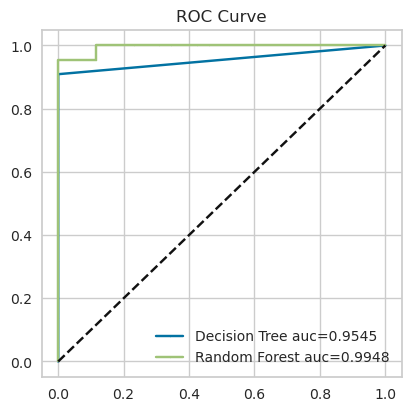

In [26]:
X_features = df.drop(['Fraud'], axis=1)
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.4)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

roc_curve_plot(y_test=y_test, X_test=X_test, classifier_models=[decision_tree, random_forest],labels=["Decision Tree","Random Forest"])



### Visualise Dicision process (Decision Tree VS Random Forest)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


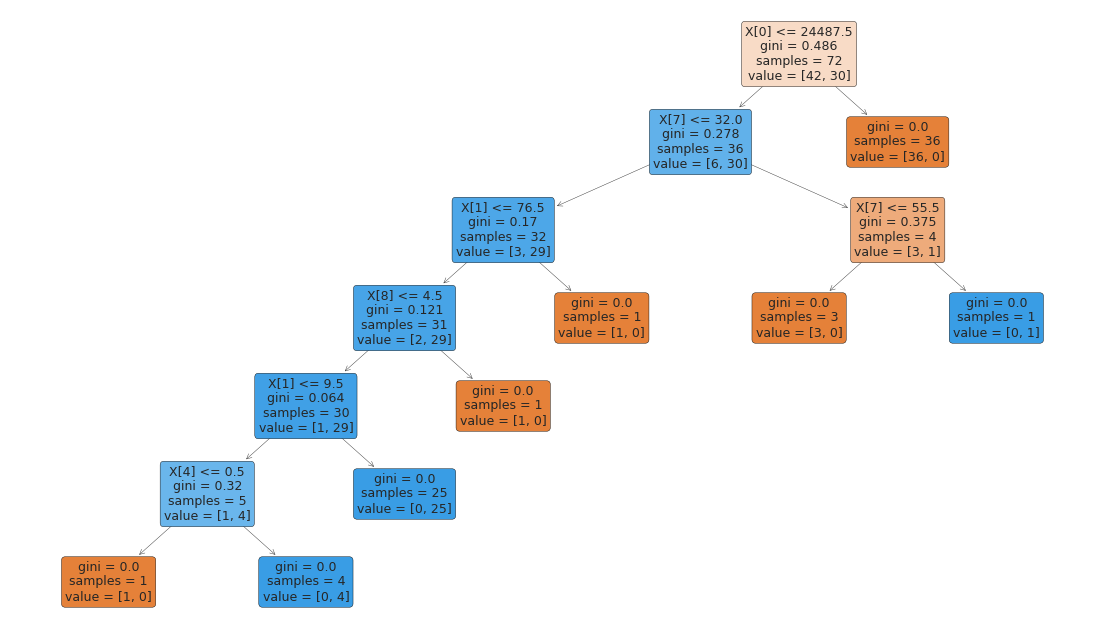

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu S

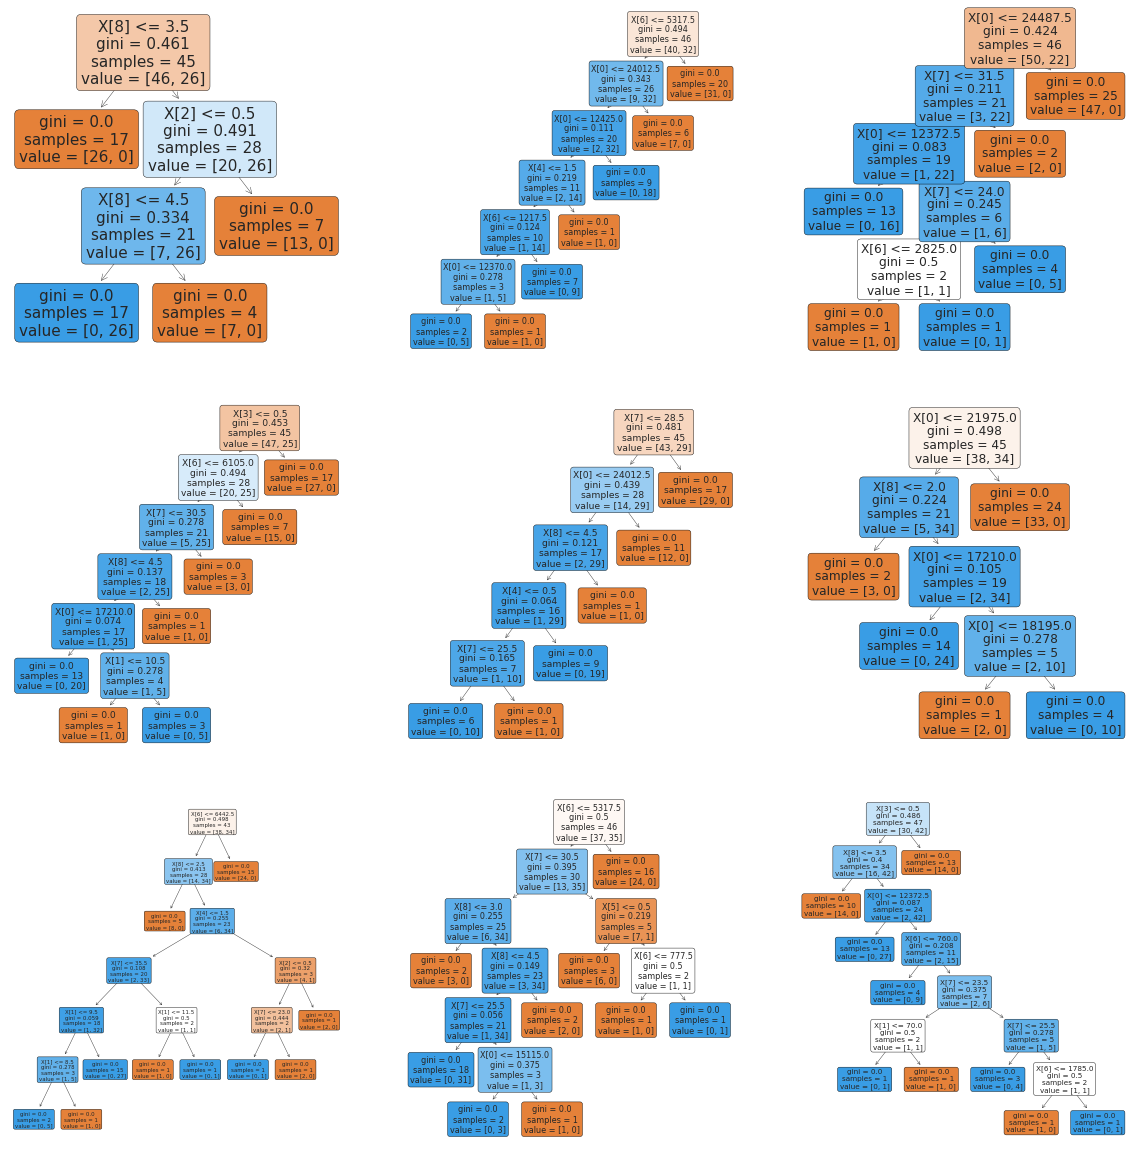

In [27]:
fig, ax = plt.subplots(figsize=(14, 8))
plot_tree(decision_tree, fontsize=9, filled=True,rounded=True)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12), nrows=3, ncols=3)
fig.tight_layout()
for i, model in enumerate(random_forest.estimators_):
    if i > 8:break
    row = int(i/3)
    col = i%3
    plot_tree(random_forest.estimators_[i], filled=True, impurity=True,rounded=True, ax=ax[row][col])
plt.show()


#### Decision tree and Random Forest feature inportance


            Decision Tree Feature Inportance
Income                              0.714286
Post-code                           0.057969
Employed                            0.000000
Home Owner                          0.000000
Education                           0.045714
Gender                              0.000000
Balance                             0.000000
Age                                 0.130357
Colour                              0.051674


<AxesSubplot:xlabel='Decision Tree Feature Inportance'>

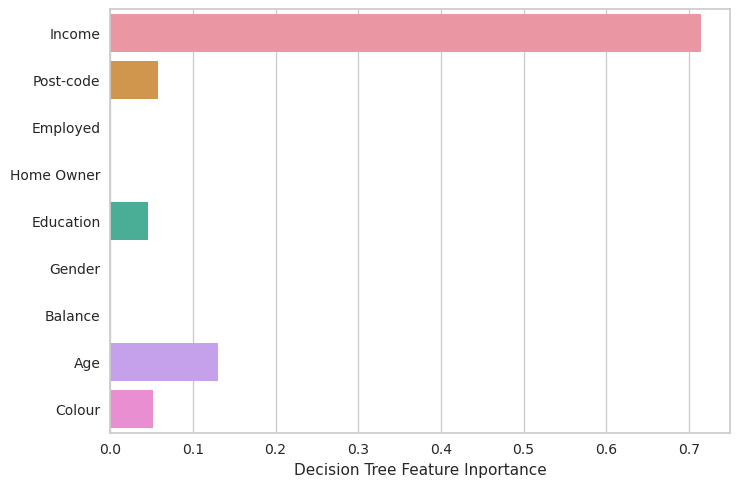

In [28]:
dt_df = pd.DataFrame(decision_tree.feature_importances_, index=X_features.columns, columns=["Decision Tree Feature Inportance"])
print(dt_df)
sns.barplot(x="Decision Tree Feature Inportance", y=X_features.columns, data=dt_df)

            Random Forest Feature Inportance
Income                              0.286950
Post-code                           0.048313
Employed                            0.027648
Home Owner                          0.058115
Education                           0.051923
Gender                              0.009101
Balance                             0.202928
Age                                 0.099320
Colour                              0.215703


<AxesSubplot:xlabel='Random Forest Feature Inportance'>

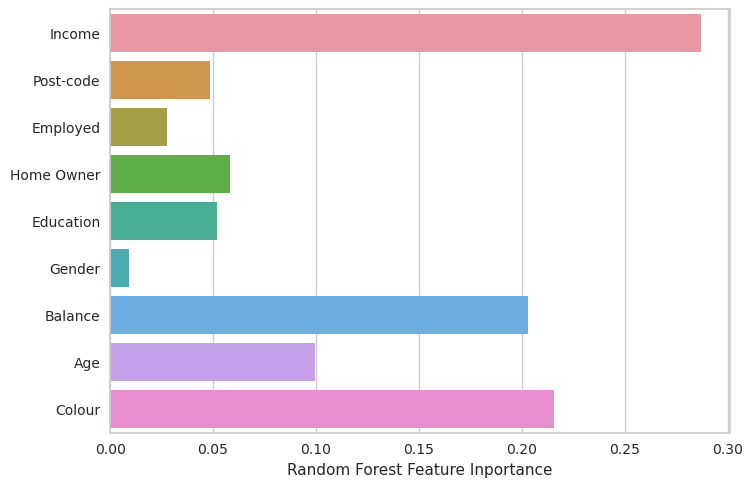

In [29]:
#random forest feature inportance
rf_df = pd.DataFrame(random_forest.feature_importances_, index=X_features.columns, columns=["Random Forest Feature Inportance"])
print(rf_df)
sns.barplot(x="Random Forest Feature Inportance", y=X_features.columns, data=rf_df)

# Unsupervised Learning (K-Means VS K-Means++)

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def inertias(X):
    inertias = []
    cluster_range = range(1,9)
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    plt.plot(cluster_range, inertias, 'bo-')
    plt.xlabel("Cluster")
    plt.ylabel("Inertia")
    plt.title('Elvow Curve')
    print(inertias)
    plt.show()

def visualise_silhouette_score(X=None, model=None):
    model.fit(X)
    visModel = SilhouetteVisualizer(model)
    visModel.fit(X)
    visModel.poof()

def scale_data(X_features):
    columns = X_features.columns
    scaler = StandardScaler()
    X_features = scaler.fit_transform(X_features)
    X_features =pd.DataFrame(X_features, columns=columns)
    return X_features

def visualise_correlation(df):
    corr = df.corr()
    unstack = corr.unstack()
    print(unstack[unstack < 1][unstack > 0.5].sort_values(ascending=False))
    # triangle mask
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(5, 5))
    sns.heatmap(corr, mask=mask, center=0, annot=True,
            fmt='.1f', square=True, cmap = 'RdYlBu_r')
    plt.show()

def pca_transform(X):
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X)
    X['pca_x'] = pca_transformed[:,0]
    X['pca_y'] = pca_transformed[:,1]
    X = X[['pca_x','pca_y']]
    print(X.head(3))
    return X

def fit_predict_plot(X, model):
    model.fit(X)
    centroids = model.cluster_centers_
    predictions = model.predict(X)
    silhouette = silhouette_score(X, predictions)
    plot_(X,predictions,centroids)
    accuracy = sum(predictions == df['Fraud']) / len(df)
    return (centroids, predictions, silhouette, accuracy)

def plot_(X,predictions,centroids):
    f, ax = plt.subplots(figsize=(6,6), ncols=1, nrows=1)
    f.suptitle("{}".format(X.columns))
    for i,column in enumerate(X):
        if i == len(X.columns)-1: break
        ax.scatter(X[predictions==0].iloc[:,lambda X: [i]],X[predictions==0].iloc[:,lambda X: [i+1]],c='blue')
        ax.scatter(X[predictions==1].iloc[:,lambda X: [i]],X[predictions==1].iloc[:,lambda X: [i+1]],c='red')
        ax.scatter(centroids[:, 0], centroids[:, 1], c='k', edgecolors='k', s=50)
    plt.show()

Income      Balance       0.676333
Balance     Income        0.676333
Employed    Home Owner    0.594028
Home Owner  Employed      0.594028
Income      Home Owner    0.529223
Home Owner  Income        0.529223
Income      Employed      0.524189
Employed    Income        0.524189
dtype: float64


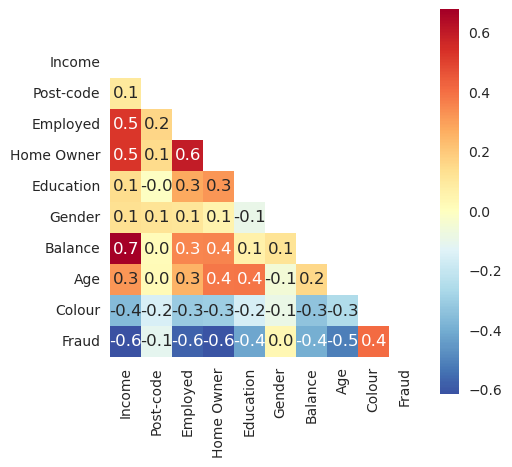

In [37]:
X_features_All = df.drop(['Fraud'], axis=1)
X_income_balance = df[['Income','Balance']]
X_employed_home_owner = df[['Employed','Home Owner']]

visualise_correlation(df)

# fit_predict_plot

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3fcddca0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3fcddca0>
Traceback 

0
1


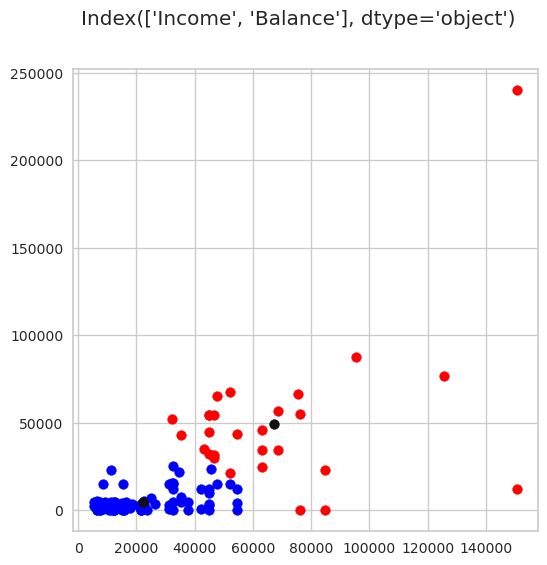

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3f88cee0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3f88cee0>
Traceback 

0
1


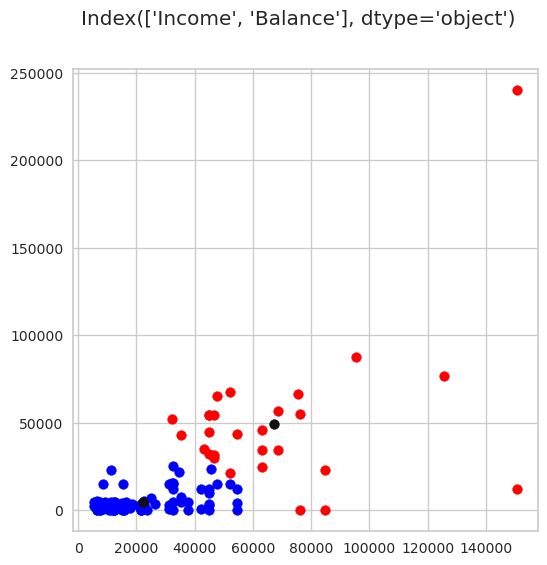

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e69faf0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e69faf0>
Traceback 

0
1


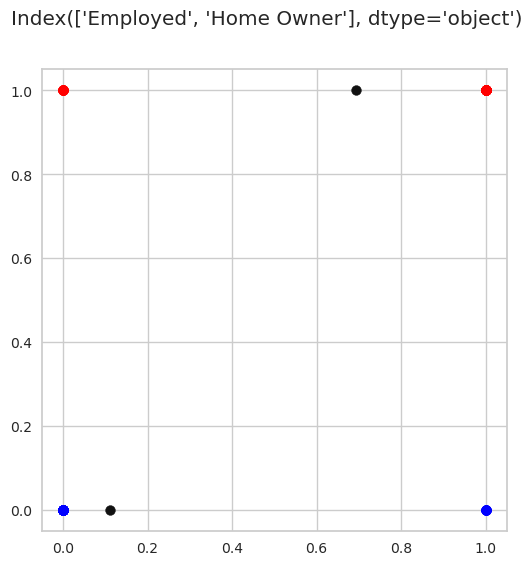

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3f244ee0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3f244ee0>
Traceback 

0
1


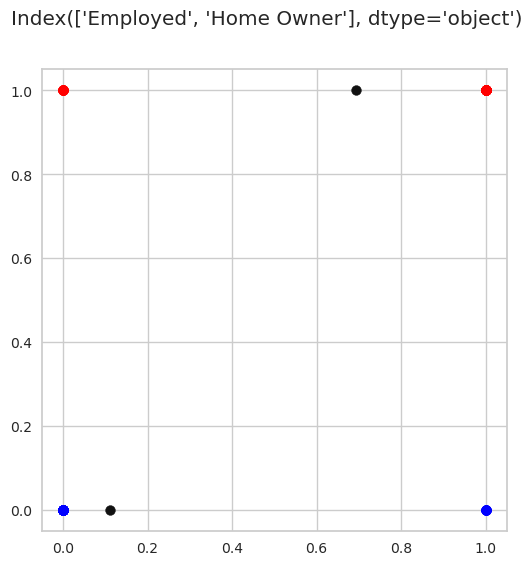

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e684f70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e684f70>
Traceback 

0
1
2
3
4
5
6
7
8


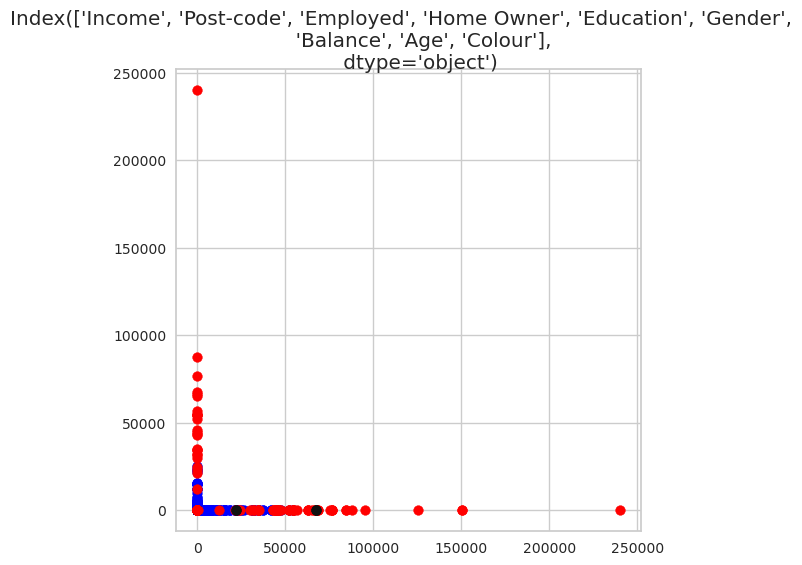

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e8ef160>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e673af0>
Traceback 

0
1
2
3
4
5
6
7
8


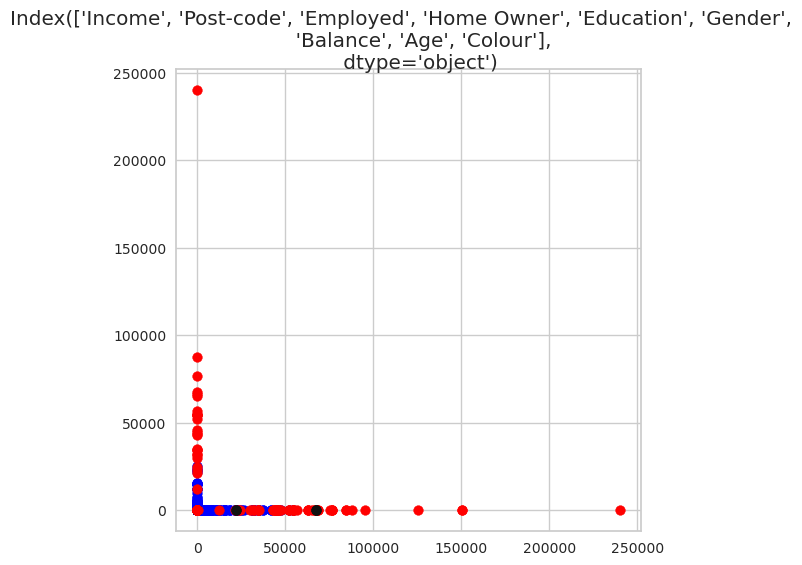

(array([[2.23248913e+04, 3.63260870e+01, 1.84782609e-01, 2.17391304e-01,
         9.89130435e-01, 4.78260870e-01, 4.84809783e+03, 3.00434783e+01,
         3.53260870e+00],
        [6.72317857e+04, 4.49642857e+01, 6.78571429e-01, 6.78571429e-01,
         1.10714286e+00, 5.71428571e-01, 4.95341071e+04, 3.77142857e+01,
         2.21428571e+00]]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32),
 0.6062675761620265,
 0.3333333333333333)

In [40]:
# Create KMeans model
kmeans = KMeans(n_clusters=2)
kmeans_plus = KMeans(n_clusters=2,init='k-means++',max_iter=1000)

fit_predict_plot(X_income_balance, kmeans)
fit_predict_plot(X_income_balance, kmeans_plus)

fit_predict_plot(X_employed_home_owner, kmeans)
fit_predict_plot(X_employed_home_owner, kmeans_plus)

fit_predict_plot(X_features_All, kmeans)
fit_predict_plot(X_features_All, kmeans_plus)

#### visualise_silhouette_score

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3f88c1f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3f88c1f0>
Traceback 

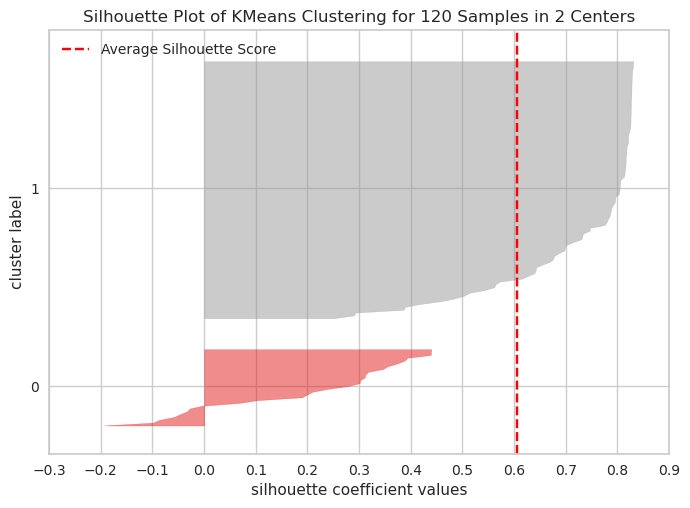

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e4a75e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e4a75e0>
Traceback 

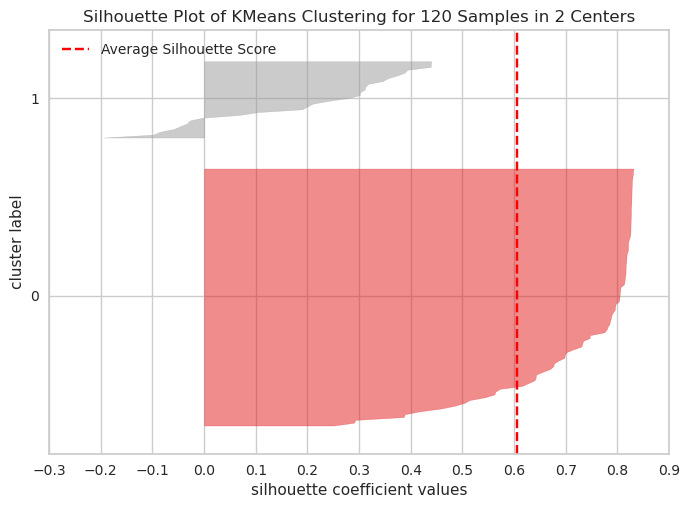

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3eb26b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3eb26b80>
Traceback 

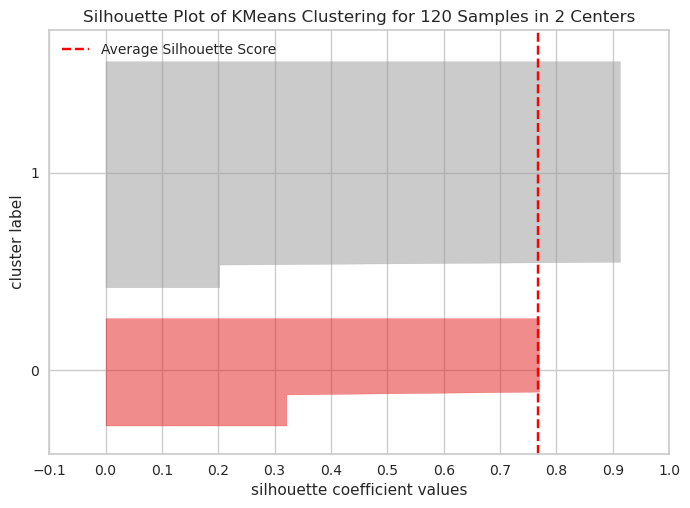

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e3ce040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3fce7310>
Traceback 

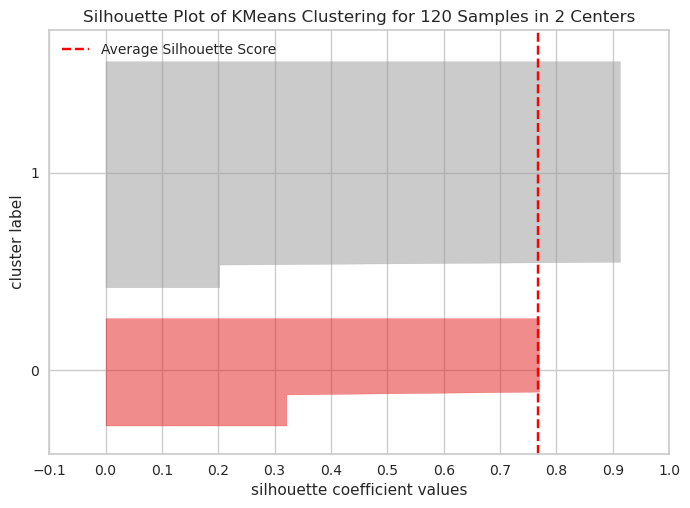

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e729040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3e729040>
Traceback 

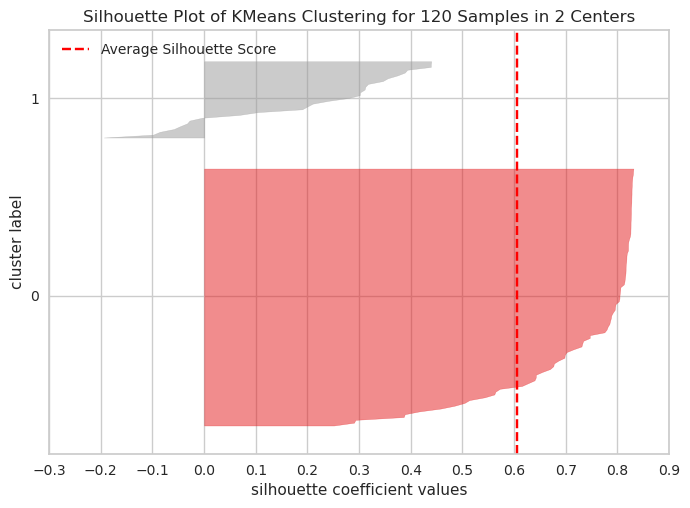

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff4df611f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff4df611f0>
Traceback 

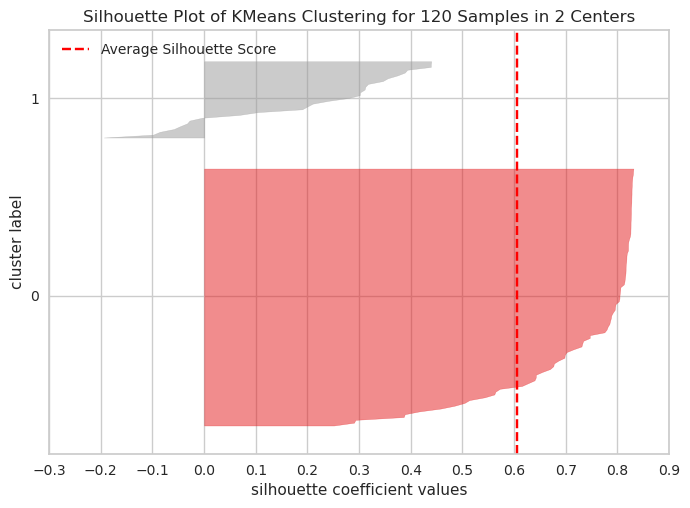

In [41]:

visualise_silhouette_score(X_income_balance,kmeans)
visualise_silhouette_score(X_income_balance,kmeans_plus)

visualise_silhouette_score(X_employed_home_owner,kmeans)
visualise_silhouette_score(X_employed_home_owner,kmeans_plus)

visualise_silhouette_score(X_features_All,kmeans)
visualise_silhouette_score(X_features_All,kmeans_plus)

#### inertias

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3f9ae040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3f9ae040>
Traceback 

[182034624243.3333, 95878831754.42548, 50322375326.97947, 34416219981.29308, 22221779329.610043, 17186531338.14964, 13702294386.333527, 10992234898.844086]


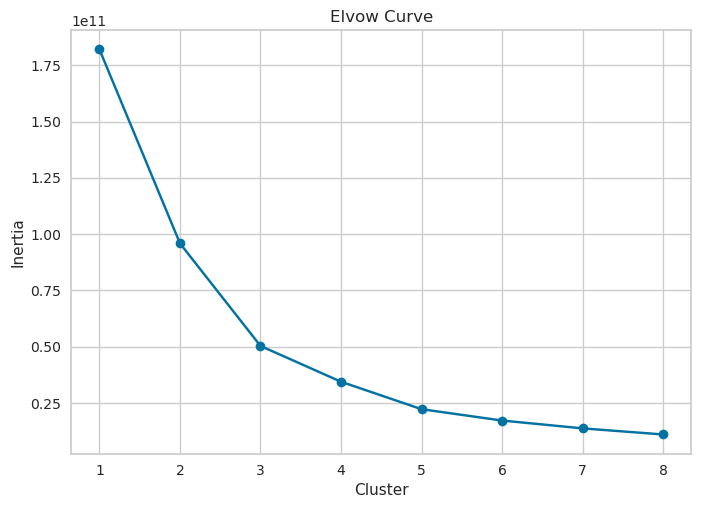

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3f9ae310>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff3f9ae310>
Traceback 

[51.525, 16.307692307692307, 7.999999999999996, 2.969321751058465e-29, 4.622231866529366e-30, 2.969321751058465e-29, 2.969321751058465e-29, 2.6365210566683504e-29]


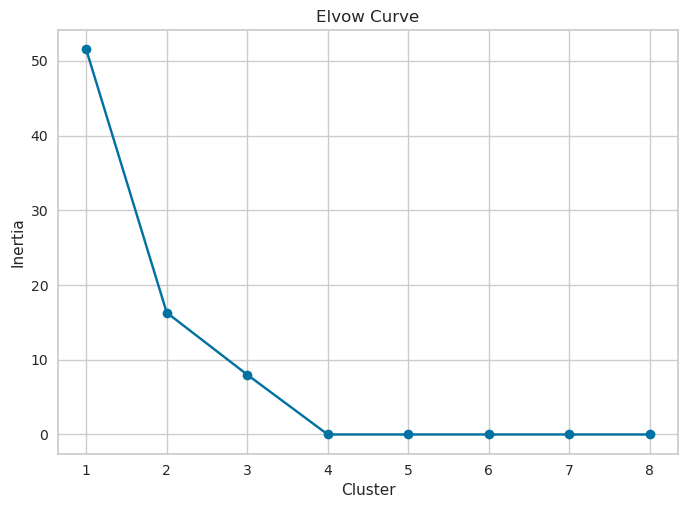

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff4df32f70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff4df32f70>
Traceback 

[182034701647.40833, 95878906245.97052, 50322449868.441345, 34416290672.438385, 22221848087.68147, 17148180410.80323, 13545740088.757393, 10884404535.010113]


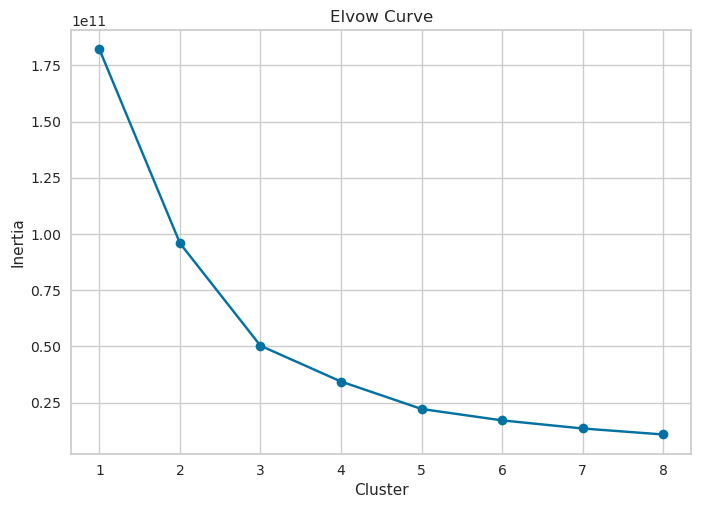

In [42]:
inertias(X_income_balance)
inertias(X_employed_home_owner)
inertias(X_features_All)
